# <center> <h1> DATS 6103: Project 3</h1></center>
## <center> <h1> Twitter API</h1></center>
### <center> <h1> Presidential election Twitter data analysis</h1></center> 
#### <center> <h1> Anamay Agnihotri</h1></center>

# 1. Importing packages

In [76]:
# General use
import importlib
import os
import keys       # Twitter credentials (identifies user)
import json
import re
import operator
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import csv
import matplotlib.pyplot as plt
import sqlite3

# Parsing and Plotting
import nltk
from nltk.corpus import stopwords
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Access API
from twython import Twython, TwythonError

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# 2. Twitter data collection

## 2.1 Establishing OAuth connection with credentials

In [2]:
def init(keychain):
    """
        Dummy function to get credential details from keychain
        
        Parameters:
          keychain: dictionary with user credentials
    
        Return Value: Needed credentials to access the Twitter API
    """
    api_key = keychain['twitter']['api_key']
    api_secret = keychain['twitter']['api_secret']
    access_token = keychain['twitter']['access_token']
    access_token_secret = keychain['twitter']['access_token_secret']
    return (api_key,api_secret,access_token,access_token_secret)

In [3]:
def APIload(api_key,api_secret,access_token,access_token_s):
    """ Takes authorization information and returns twython object
        used for tweet extraction.
        
        Parameters:
           api_key: Client key
        api_secret: Client secret (keep hidden from application)
      access_token: Access token from Twitter server
    access_token_s: Token secret for server
    
        Return Value: Twython object
    """
    auth = Twython(api_key,api_secret,access_token,access_token_s)
    return auth

In [4]:
importlib.reload(keys)
keychain = keys.keychain
key,secret,a_token,a_secret = init(keychain)
Auth = APIload(key,secret,a_token,a_secret)

In [5]:
def getLimit(auth):
    """ Function to get count of remaining requests to the twitter server.
        Maximum 180 requests per 15 mins.
        
        Parameters:
          auth: twython authorization object
    
        Return Value: number of requests remaining to the server
    """
    Limit = auth.get_lastfunction_header('x-rate-limit-remaining')
    if Limit == None:
        print("Rate limit error!")
    else:
        return int(Limit)

In [172]:
query = """(cat) AND (dog) -filter:retweets"""
object1 = Auth.search(q=query,count=100,lang='en',tweet_mode='extended')
getLimit(Auth) #number of requests left

178

In [173]:
print(len(object1["statuses"]))
object1["statuses"][5] # one tweet

100


{'created_at': 'Thu Dec 12 17:24:38 +0000 2019',
 'id': 1205176647554482176,
 'id_str': '1205176647554482176',
 'full_text': '@kat_drinkard My large, weird cat is the only reason I get out of bed and can hold down a job, because she needs me. I spent a year making a list of pros/cons relating to getting a dog in Los Angeles. Apartments, dog care costs, vet costs. Everything was weighed and THEN I got her. https://t.co/T5X2KOQa61',
 'truncated': False,
 'display_text_range': [14, 282],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'kat_drinkard',
    'name': 'Kateri Drinkard',
    'id': 4515872309,
    'id_str': '4515872309',
    'indices': [0, 13]}],
  'urls': [],
  'media': [{'id': 1205176642752020481,
    'id_str': '1205176642752020481',
    'indices': [283, 306],
    'media_url': 'http://pbs.twimg.com/media/ELmlxXLVAAE1Y21.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/ELmlxXLVAAE1Y21.jpg',
    'url': 'https://t.co/T5X2KOQa61',
    'di

## 2.2 Tweet acquisition pipeline

### Getting tweets by query

In [19]:
def fornewquery(auth,query,text,location,date,time):
    """ Function to get tweets (max 100) for a particular query
        and write the search metadata to external file.
        
        Parameters:
              auth: twython api object
             query: search query
              text: list to append tweet text
          location: list to append tweet location
              date: list to append tweet date
              time: list to append tweet time
    """
    try:
        object1 = auth.search(q=query,count=100,lang='en',tweet_mode='extended')
        Limit = getLimit(auth)
        print("Query successful. Requests remaining: ",Limit)
    except TwythonError as e:
        print(e)

    for i in range(0,len(object1['statuses'])):
        text.append(object1['statuses'][i]['full_text'])
        location.append(object1['statuses'][i]['user']['location'])
        date.append(object1['statuses'][i]['created_at'][4:10])
        time.append(object1['statuses'][i]['created_at'][11:19])
    file = "./data/Init_metadata:"+query+".json"
    with open(os.path.realpath(file), 'w') as outfile:
        json.dump(object1['search_metadata'], outfile)
    return

In [169]:
text = []
location = []
date = []
time = []
query = """(cat) AND (dog) -filter:retweets"""
meta_init = "./data/Init_metadata:"+query+".json"     # initial query metadata
meta_top = './data/Top_metadata:'+query+'.json'       # metadata to track the top of query list
meta_bottom = './data/Bottom_metadata:'+query+'.json' # metadata to track the bottom of query list

In [174]:
# The startpoint should only be called ONCE for each query.
fornewquery(Auth,query,text,location,date,time)
with open(os.path.realpath(meta_init)) as f:
    startpoint_metadata = json.load(f)

Query successful. Requests remaining:  177


In [175]:
text

['Deal #4037 Pet Strap Leash Dog Small Dog Vest-Style Bow Evening Dress Chest Strap Dog And Cat Universal Dog Traction Rope | Gift Fashion Deals Style ⌚ Dec,12,2019 05:25:11 PM 🔗  https://t.co/Qr0NnZtNTl https://t.co/l5XHy3qt4n',
 '@kat_drinkard My large, weird cat is the only reason I get out of bed and can hold down a job, because she needs me. I spent a year making a list of pros/cons relating to getting a dog in Los Angeles. Apartments, dog care costs, vet costs. Everything was weighed and THEN I got her. https://t.co/T5X2KOQa61',
 '@macawcaw123 Milo (cat) &amp; Ludwig (dog) 🥰🥰 https://t.co/YeJtODTwty',
 'Now Hiring: Associate Veterinarian, Berkeley Dog and Cat Hospital, Berkeley, CA | Berkeley Dog and Cat Hospital: Berkeley, California | https://t.co/fg0maqJ8rx #jobs',
 'Here Are The Most Popular Dog and Cat Names of 2019 https://t.co/Ndf8qg0mc2 #fun https://t.co/vlgbJvs3DG',
 'CAT &amp; DOG — I become a puppy when I see you. Feel like I’m your cat, I’m your dog.',
 'when people o

### Getting more tweets: Parsing through pages (pagination)

In [23]:
def retrieve_max_id(metadata):
    """ 
        Function to retrieve `max_id` parameter from metadata. `Max_id` keeps
        track of the bottom of the tweet list and is needed to obtain the next 
        batch of tweets.
        
        Parameters:
          metadata: json containing the search metadata from previous request
    
        Return Value: max_id parameter
    """
    try:
        next_results = metadata['next_results']
        pattern = r'\?max_id=(\d*)&'
        regex = re.compile(pattern, re.S)
        max_id = regex.search(next_results)
        return(int(max_id[1]))
    except:
        print("Result error.")

In [25]:
def boom(auth,query,metadata,text,location,date,time):
    """ 
        Function to retrive tweets until server error or rate-limit 
        exceeded. Should retrieve approx 17000 tweets when fully functional
        (rate limit resets every 15 mins).
        
        Parameters:
              auth: twython api object
             query: search query
          metadata: json containing the search metadata from
                    previous server query
              text: global list for tweet text
          location: global list for tweet location
              date: tweet date list to be appended
              time: tweet time list to be appended
    
        Return Value: appended lists and last request object
                      for further retrieval.
    """
    file = './data/Bottom_metadata:'+query+'.json'
    try:
        with open(os.path.realpath(file)) as f:
            metadata_end = json.load(f)
    except:
        print("Nothing to load from endpoint json.")
        pass
        
    Limit = getLimit(auth)
    
    try:
        while Limit > 0:
            Limit = getLimit(auth)
            max_id = retrieve_max_id(metadata)
            try:
                object1 = auth.search(q=query,count=100,lang='en',tweet_mode='extended',max_id=max_id)
                metadata = object1['search_metadata']
                print("Query successful. Requests remaining: ",Limit)
            except Exception as ex:
                template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                message = template.format(type(ex).__name__, ex.args)
                print(message)
                pass
            for j in range(0,len(object1['statuses'])):
                text.append(object1['statuses'][j]['full_text'])
                location.append(object1['statuses'][j]['user']['location'])
                date.append(object1['statuses'][j]['created_at'][4:10])
                time.append(object1['statuses'][j]['created_at'][11:19])
            metadata_end = object1['search_metadata']
    except TwythonError as e:
        print(e)
        pass
    print("Terminated.")
    
    try:
        with open(os.path.realpath(file), 'w') as outfile:
            json.dump(metadata_end, outfile)
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message) 
    return (metadata_end)

In [26]:
# for first batch
endpoint_metadata = boom(Auth,query,startpoint_metadata,text,location,date,time)
with open(os.path.realpath(meta_bottom)) as f:
    endpoint_metadata = json.load(f)

Nothing to load from endpoint json.
Query successful. Requests remaining:  175
Query successful. Requests remaining:  174
Query successful. Requests remaining:  173
Query successful. Requests remaining:  172
Query successful. Requests remaining:  171
Query successful. Requests remaining:  170
Query successful. Requests remaining:  169
Query successful. Requests remaining:  168
Query successful. Requests remaining:  167
Query successful. Requests remaining:  166
Query successful. Requests remaining:  165
Query successful. Requests remaining:  164
Query successful. Requests remaining:  163
Query successful. Requests remaining:  162
Query successful. Requests remaining:  161
Query successful. Requests remaining:  160
Query successful. Requests remaining:  159
Query successful. Requests remaining:  158
Query successful. Requests remaining:  157
Query successful. Requests remaining:  156
Query successful. Requests remaining:  155
Query successful. Requests remaining:  154
Query successful. 

### Getting new tweets

In [27]:
def retrieve_since_id(metadata):
    """ 
        Function to retrieve `since_id` parameter from metadata. `since_id`
        keeps track of the top of the tweet list and is needed to obtain 
        newer incoming tweets.
        
        Parameters:
          metadata: json containing the search metadata from initial request
                
        Return Value: since_id parameter
    """
    refresh_url = metadata['refresh_url']
    pattern = r'\?since_id=(\d*)&'
    regex = re.compile(pattern, re.S)
    since_id = regex.search(refresh_url)
    return(int(since_id[1]))

In [28]:
def get_new_tweets(auth,query,metadata,text,location,date,time):
    """ Function to get all new tweets since initial server
        call in previous session for a particular query.
        
        Parameters:
              auth: twython api object
             query: search query
          metadata: json containing the search metadata from
                    previous server query
              text: tweet text list to be appended
          location: tweet location list to be appended
              date: tweet date list to be appended
              time: tweet time list to be appended
    
        Return Value: twython object with new tweets
    """
    file = './data/Top_metadata:'+query+'.json'
    since_id = retrieve_since_id(metadata) # can't initialize getLimit before call to the server
    try:
        latest = auth.search(q=query,count=100,lang='en',tweet_mode='extended',since_id=since_id)
        Limit = getLimit(auth)
        if len(latest['statuses'])==0:
            print("No new results. Requests remaining: ",Limit)
            
        while len(latest['statuses'])>0:
            Limit = getLimit(auth)
            print("Query successful. Requests remaining: ",Limit)
            for i in range(0,len(latest['statuses'])):
                text.append(latest['statuses'][i]['full_text'])
                location.append(latest['statuses'][i]['user']['location'])
                date.append(latest['statuses'][i]['created_at'][4:10])
                time.append(latest['statuses'][i]['created_at'][11:19])
            since_id = retrieve_since_id(latest['search_metadata'])
            latest = auth.search(q=query,count=100,lang='en',tweet_mode='extended',since_id=since_id)
            
        with open(os.path.realpath(file), 'w') as outfile:
            json.dump(latest['search_metadata'], outfile)
                
        with open(os.path.realpath(file)) as f:
            metadata = json.load(f)
        return(metadata)
    except TwythonError as e:
        print(e)
        file = './data/Init_metadata:'+query+'.json'
        with open(os.path.realpath(file)) as f:
            metadata = json.load(f)
        return(metadata)

In [29]:
# only for the first new call from startpoint
top_metadata = get_new_tweets(Auth,query,startpoint_metadata,text,location,date,time)

Twitter API returned a 429 (Too Many Requests), Rate limit exceeded


In [ ]:
with open(meta_top) as f:
    top_metadata = json.load(f)

### Keep getting real-time data 

In [329]:
# for all future calls for the query
top_metadata = get_new_tweets(Auth,query,top_metadata,text,location,date,time)
endpoint_metadata = boom(Auth,query,endpoint_metadata,text,location,date,time)

Query successful. Requests remaining:  179
Query successful. Requests remaining:  178
Query successful. Requests remaining:  177
Query successful. Requests remaining:  176
Query successful. Requests remaining:  175
Query successful. Requests remaining:  174
Query successful. Requests remaining:  173
Query successful. Requests remaining:  172
Query successful. Requests remaining:  171
Query successful. Requests remaining:  170
Query successful. Requests remaining:  169
Query successful. Requests remaining:  168
Query successful. Requests remaining:  167
Query successful. Requests remaining:  166
Query successful. Requests remaining:  165
Query successful. Requests remaining:  164
Query successful. Requests remaining:  163
Query successful. Requests remaining:  162
Query successful. Requests remaining:  161
Query successful. Requests remaining:  160
Query successful. Requests remaining:  159
Query successful. Requests remaining:  158
Query successful. Requests remaining:  157
Query succe

# 3. Presidential candidates' twitter presence

## 3.1 Tweet extraction

In [31]:
text = []
location = []
date = []
time = []
# Donald Trump, Joe Walsh, Hillary Clinton, Bernie Sanders, Joe Biden, Andrew Yang
query = """ "andrew yang" -filter:retweets"""
meta_init = "./data/Init_metadata:"+query+".json"     # initial query metadata
meta_top = './data/Top_metadata:'+query+'.json'       # metadata to track the top of query list
meta_bottom = './data/Bottom_metadata:'+query+'.json' # metadata to track the bottom of query list

In [33]:
fornewquery(Auth,query,text,location,date,time)
with open(meta_init) as f:
    startpoint_metadata = json.load(f)

endpoint_metadata = boom(Auth,query,startpoint_metadata,text,location,date,time)
with open(meta_bottom) as f:
    endpoint_metadata = json.load(f)

top_metadata = get_new_tweets(Auth,query,startpoint_metadata,text,location,date,time)

In [ ]:
# for all subsequent requests after initial timeout
top_metadata = get_new_tweets(Auth,query,top_metadata,text,location,date,time)
endpoint_metadata = boom(Auth,query,endpoint_metadata,text,location,date,time)

## 3.2 Save candidates' tweet data as csv

In [34]:
d = {'Text':text,'Location':location,'Date':date,'Time':time}
df = pd.DataFrame(data=d)
df = df.drop_duplicates()
#df.to_csv("Yang.csv",sep=",")

## 3.3 Tweet sentiment extraction

In [178]:
trump = pd.read_csv("data/Trump.csv").drop('Unnamed: 0',axis=1)
bernie = pd.read_csv("data/Bernie.csv").drop('Unnamed: 0',axis=1)
clinton = pd.read_csv("data/Hillary.csv").drop('Unnamed: 0',axis=1)
walsh = pd.read_csv("data/Walsh.csv").drop('Unnamed: 0',axis=1)
biden = pd.read_csv("data/Biden.csv").drop('Unnamed: 0',axis=1)
yang = pd.read_csv("data/Yang.csv").drop('Unnamed: 0',axis=1)

In [179]:
print(bernie.shape)
bernie.head(10)

(35705, 4)


,Text,Location,Date,Time
0,@JillayneMC @RachelLucca1 @jbarro @Susan_Hennessey @BernieSanders Only two candidates consistently beat Trump in the polls. Sanders and Biden. And the race will tighten so even that is far from a guarantee.,The United States of America,Dec 11,21:07:36
1,"@StuntQueenAgncy @DinahCharlette @FlyThaiMMA That must makes it hard to believe you're literally saying you want Bernie Sanders to be a white savior. Or does it just annoy you that he refuses to accept that role, so you can dismiss him without having to actually have good reason?",Austin TX,Dec 11,21:07:31
2,"@Andre80004825 @BernieSanders @KamalaHarris @SenSanders nah..bruh That's your thought... not mine. Bernie is my candidate. But, Harris will be a good AG.👌🏿 #BERNIESANDERS2020 ...",East Coast,Dec 11,21:07:31
3,@PaprikaPink @m_mendozaferrer Or because it’s a bs stance to hold onto 50 years later when his son is very much involved in Bernie’s life,NaN,Dec 11,21:07:31
4,The green here is what happens to the Wal-Mart heirs' fortune under Bernie's Wealth Tax proposal. That's a log scale. They'll be billionaires for 75 years even if their income is 0 dollars. https://t.co/0i3hxjlvhd,"Westlake Village, California",Dec 11,21:07:28
5,@alvinhrfm7 @TIME @GretaThunberg Thanks for stats . If China is doing what there doing then Bernie Sanders and Elizabeth Warren plans on 90 trillion to spend on climate will cripple America but not help climate control,"Queens, NY",Dec 11,21:07:28
6,"@jakestewy @johniadarola Again, when did I say that? BTW, the majority of Sanders supporters are female. Bye Hillbot.","Los Angeles, CA",Dec 11,21:07:26
7,"@NoisyHuevos need 2 WR for this week. Wyt? Amari Cooper, AJ Brown, Emmanuel Sanders?",NaN,Dec 11,21:07:25
8,"@Djahnarmyskol @carbo_bernie @brithume Mainstream is recognized through the years as ABC, CBS, NBC and their affiliates and to some extent includes CNN and PBS. FOX and FOX News are considered outliers in the general discussion of the cable and broadcast news media.","Pennsylvania, USA",Dec 11,21:07:23
9,"@ImNotOwned @danielmarans whatever, please vote for Sanders and not Warren and you can be surprised by whatever you like",NaN,Dec 11,21:07:23


In [38]:
def sentiment_scorer(data):
    """ Function to get a quick "feel" of the tweets extracted.
        Uses the Vader sentiment analyser.
    """
    scores = []
    for each in data.Text:
        if type(each)==str:
            snt = analyser.polarity_scores(each.lower())
            sent_score = snt['compound']
        else:
            sent_score=0
        scores.append(sent_score)
    data["sentiment_score"] = scores
    return data

In [154]:
%%time
trump = sentiment_scorer(trump)
bernie = sentiment_scorer(bernie)
clinton = sentiment_scorer(clinton)
walsh = sentiment_scorer(walsh)
biden = sentiment_scorer(biden)
yang = sentiment_scorer(yang)

CPU times: user 1min 35s, sys: 1.42 s, total: 1min 36s
Wall time: 2min 8s


In [155]:
print(trump.shape)
trump.head(10)

(35405, 5)


,Text,Location,Date,Time,sentiment_score
0,The Democrats launched their latest coup and impeachment sham against President Trump would ruin his... https://t.co/wG2jzSowmz,Pennsylvania,Dec 11,04:35:30,-0.5106
1,"@Fight_4_USA_Now @RoseAnnDeMoro As long as that nominee hasn't been shoved down our throats like Hillary was via DNC and corporate media rigging... sure thing. Otherwise, people are going to have to face the fact that establishment democrats really do want to give Trump 4 more years.",Earth,Dec 11,04:35:30,0.6573
2,@realDonaldTrump God bless you President Trump. We love you!!#TRUMP2020Landside,NaN,Dec 11,04:35:29,0.8652
3,@SpeakerPelosi @RepRichardNeal Great deal president Trump made. Thank God he's our president,"Texas, USA",Dec 11,04:35:29,0.8271
4,@MysterySolvent Trump!,"Cape May, NJ",Dec 11,04:35:29,0.0000
5,"This is what trump promotes, gun violence, and as long as the NRA continues to buy off Corrupt Republican cockroaches it will continue.",NaN,Dec 11,04:35:29,-0.6249
6,@BettyBunda1 @lesbianintell since trump said so?,USA,Dec 11,04:35:29,0.0000
7,@MSNBC Is there anyone in the Trump administration who is not a crook? All of this is just mind blowing and it seems like there is no punishment for their lawlessness.,NaN,Dec 11,04:35:29,-0.4404
8,@charliekirk11 Trump will flip Minnesota and Nevada as well.,"California, USA",Dec 11,04:35:29,0.2732
9,Yep it sure looks like the majority of people dont like trump... hahaha he's more popular then ever!! https://t.co/L7EE1uOKN5,"Florida, USA",Dec 11,04:35:28,0.8501


## 3.4 Store data in SQL database

In [50]:
conn = sqlite3.connect('Candidates.db') 
trump.to_sql('Trump', conn, if_exists='replace', index = False)
bernie.to_sql('Bernie', conn, if_exists='replace', index = False)
clinton.to_sql('Clinton', conn, if_exists='replace', index = False)
walsh.to_sql('Walsh', conn, if_exists='replace', index = False)
biden.to_sql('Biden', conn, if_exists='replace', index = False)
yang.to_sql('Yang', conn, if_exists='replace', index = False)

# 4. Analyzing presidential candidates' twitter feed

## 4.1 Twitter feed sentiment

In [158]:
diction = {"Trump":sum(trump.sentiment_score)/len(trump.sentiment_score),"Clinton":sum(clinton.sentiment_score)/len(clinton.sentiment_score),
          "Biden":sum(biden.sentiment_score)/len(biden.sentiment_score),"Bernie":sum(bernie.sentiment_score)/len(bernie.sentiment_score),
          "Walsh":sum(walsh.sentiment_score)/len(walsh.sentiment_score),"Yang":sum(yang.sentiment_score)/len(yang.sentiment_score)}

In [159]:
df = pd.DataFrame.from_dict(diction,orient="index",columns=["AverageSentiment"])
df = df.reset_index()
df = df.rename({"index":"Candidate"},axis=1)

In [160]:
fig = px.bar(df, x='Candidate', y='AverageSentiment', color='AverageSentiment',
             labels={'AverageSentiment':"Average tweet sentiment"}, height=400,
            color_continuous_scale=px.colors.diverging.Tealrose_r,title="Twitter feed sentiment analysis")
fig.show()

## 4.2 Word clouds

In [161]:
def Word_clouder(dictionary):
    """
        Dummy function to create word cloud using frequency 
        dictionary.
    """
    wordcloud = WordCloud(width=800, height=400)
    wordcloud.generate_from_frequencies(frequencies=dictionary)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [51]:
def freq_dict(data,StopWords):
    """
        Function to obtain frequency count of words in twitter feed.
        Cleans data and filters out common and non-informative words
        (stopwords) from result.
        
        Parameters:
              data: candidate dataset
         StopWords: words to exclude from dictionary
        
        Return value: sorted dictionary of word frequency count
        
    """
    full_text = r""""""
    for each in data:
        if type(each)==str:
            full_text+=each.lower()
            
    tokens = nltk.tokenize.word_tokenize(full_text)
    words = [word for word in tokens if word.isalpha()]
    words = [word for word in words if word not in StopWords]
    fdist1 = nltk.FreqDist(words)
    filtered_word_freq = dict((word, freq) for word, freq in fdist1.items())
    sorted_d = dict(sorted(filtered_word_freq.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [57]:
stop_words = stopwords.words('english')
set(stop_words)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [98]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","trump","realdonaldtrump","would"])
trump_dict = freq_dict(trump.Text,stop_words)

In [99]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","hillary","clinton","would"])
clinton_dict = freq_dict(clinton.Text,stop_words)

In [100]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","sanders","bernie","berniesanders","would"])
bernie_dict = freq_dict(bernie.Text,stop_words)

In [101]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","walsh","joe","would","walshfreedom"])
walsh_dict = freq_dict(walsh.Text,stop_words)

In [102]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","joe","biden","would"])
biden_dict = freq_dict(biden.Text,stop_words)

In [104]:
stop_words = stopwords.words('english')
stop_words.extend(["https","amp","u","andrew","yang","andrewyang","yanggang","would"])
yang_dict = freq_dict(yang.Text,stop_words)

### Donald Trump

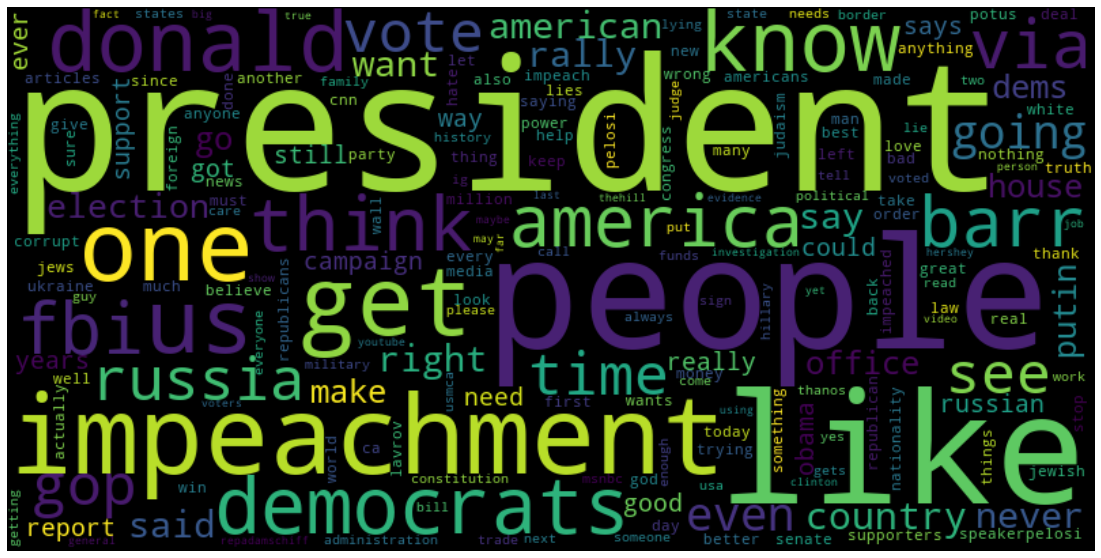

In [167]:
Word_clouder(trump_dict)

### Bernie Sanders

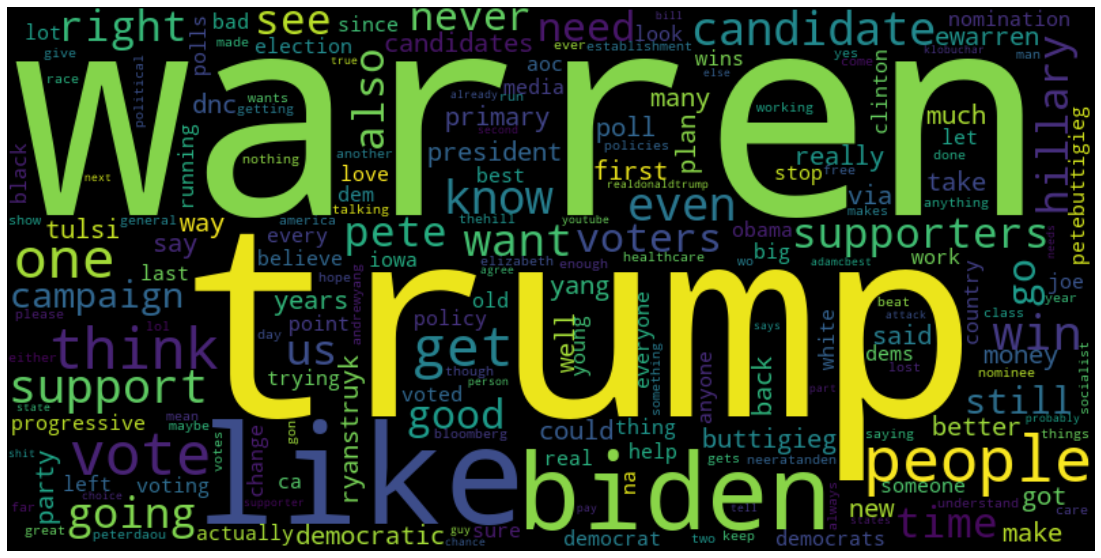

In [80]:
Word_clouder(bernie_dict)

### Hillary Clinton

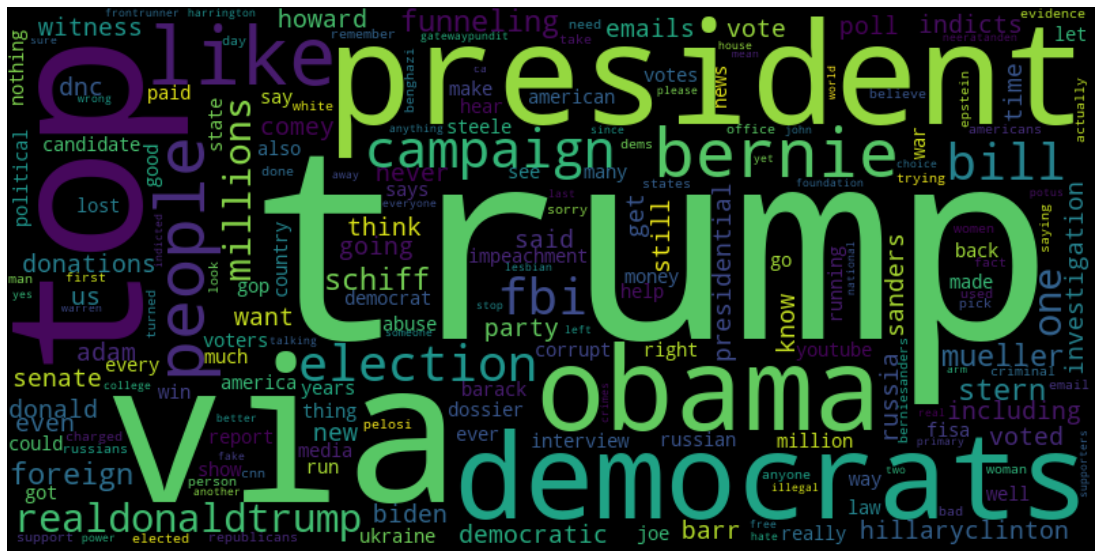

In [82]:
Word_clouder(clinton_dict)

### Joe Walsh

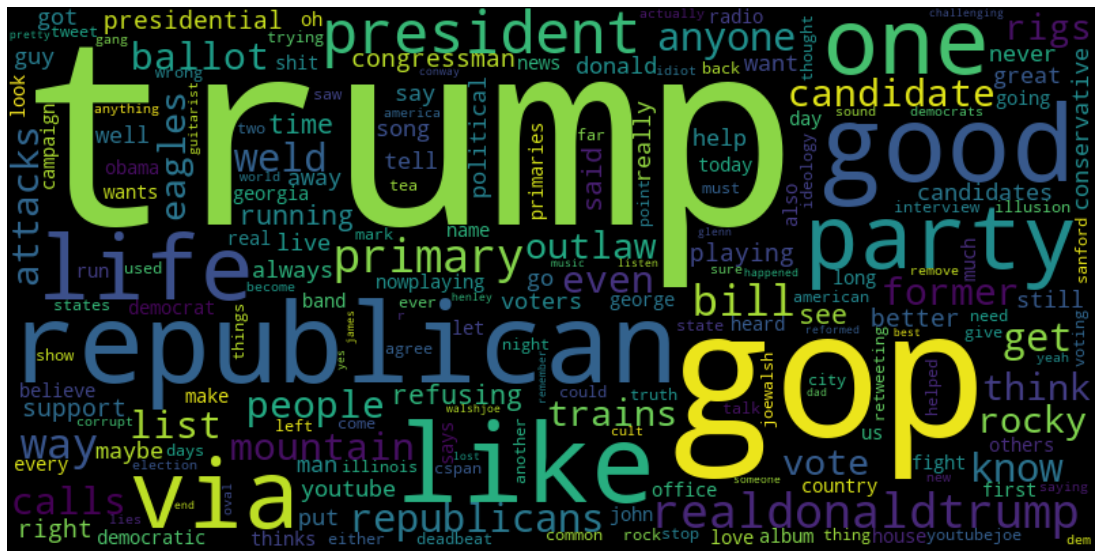

In [88]:
Word_clouder(walsh_dict)

### Joe Biden

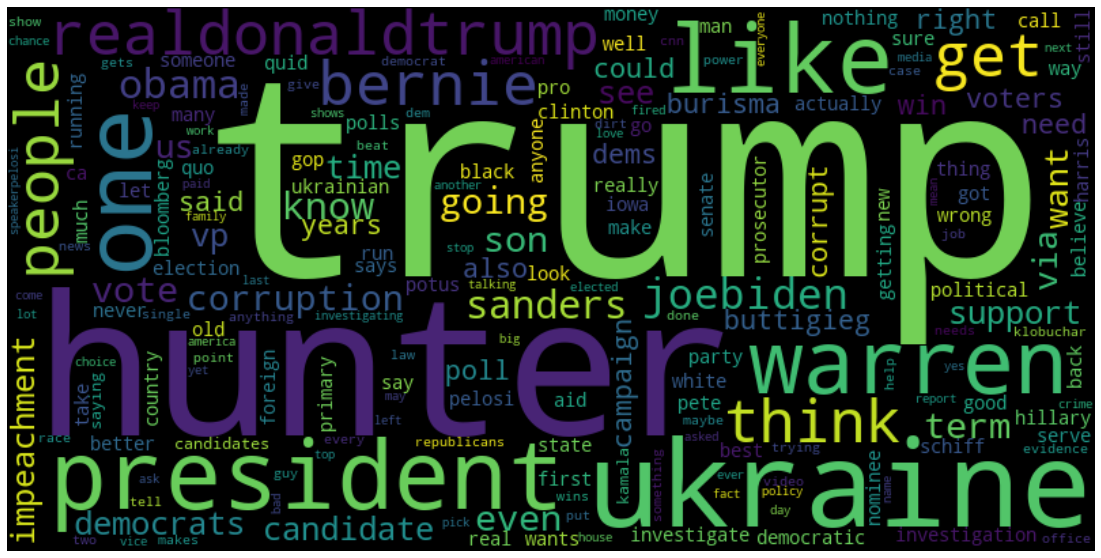

In [91]:
Word_clouder(biden_dict)

### Andrew Yang

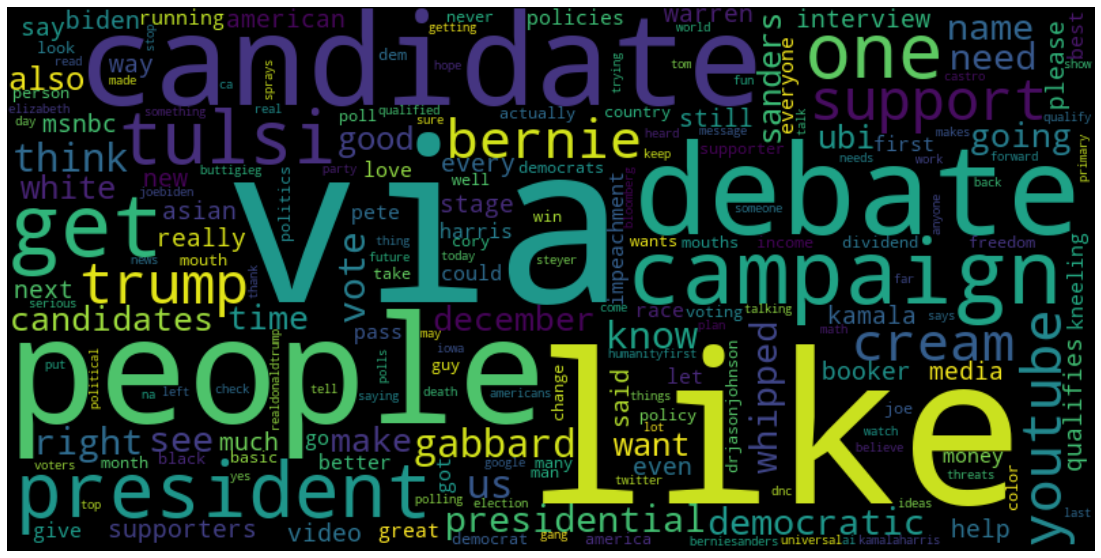

In [105]:
Word_clouder(yang_dict)

## 4.3 Tweet locations

In [ ]:
import us
state_abbr = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", 
              "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME",
              "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
              "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI",
              "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
Locations = []

Locations.extend(list(trump.Location))
Locations.extend(list(clinton.Location))
Locations.extend(list(bernie.Location))
Locations.extend(list(walsh.Location))
Locations.extend(list(biden.Location))
Locations.extend(list(yang.Location))

In [144]:
def LocationGetter(data):
    """
        Function to get dataframe of tweet location and it's
        corresponding frequency.
        
        Parameter:
             data: candidate dataset
        
        Return value:
             lister2: dataframe with location frequencies
    """
    lister = []
    lister2 = []
    locs = [each for each in data if each !=""] # remove empty strings
    for text in locs:
        if type(text)==str:
            for each in us.STATES:                       # all US states (spelled)
                if str(each).lower() in text.lower():
                    lister.append(str(each))
            for each in state_abbr:                      # all US states (abbreviated)
                if each.lower() in text.lower():
                    lister.append(each)
    for each in lister:
        lister2.append(str(us.states.lookup(each).abbr))
        
    lister2 = nltk.FreqDist(lister2)
    lister2 = pd.DataFrame.from_dict(lister2,orient="index",columns=["count"])
    lister2 = lister2.reset_index()
    lister2 = lister2.rename({"index":"code"},axis=1)
    return lister2

In [149]:
location_df = LocationGetter(Locations)
location_df.head(10)

,code,count
0,PA,4904
1,IA,11397
2,VA,3968
3,AR,10825
4,TX,5658
5,CA,20303
6,MA,7017
7,NJ,1682
8,AL,12073
9,OR,21392


In [147]:
df = location_df
fig = go.Figure(data=go.Choropleth(
    locations=df['code'], # Spatial coordinates
    z = df['count'].astype(int), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "No. of tweets"))

fig.update_layout(title_text = 'Tweet density by State', geo_scope='usa')
fig.show()